# Mevsimsel Olmayan Zaman Serisi Tahminleri için Basit ARIMA Modeli

Bu zorluktaki hedefimiz, zaman serisi analizinin temel kavramlarını tek boyutlu verilere uygulamaktır

Bu zorluklarda şu adımları izleyeceğiz:
1. verileri yükleme ve görselleştirme;
2. modellerimizi eğitme ve tahminler yapma;

##  1. Veri Yükleme
Zorlukta kullanacağımız zaman serisini yükleyerek başlayalım. Veri setini CSV dosyası olarak indirmek için aşağıdaki satırı çalıştırın, ardından CSV'yi bir DataFrame'e yükleyin.

In [1]:
!curl https://d32aokrjazspmn.cloudfront.net/materials/www_usage.csv > data/www_usage.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0    678      0 --:--:-- --:--:-- --:--:--   679


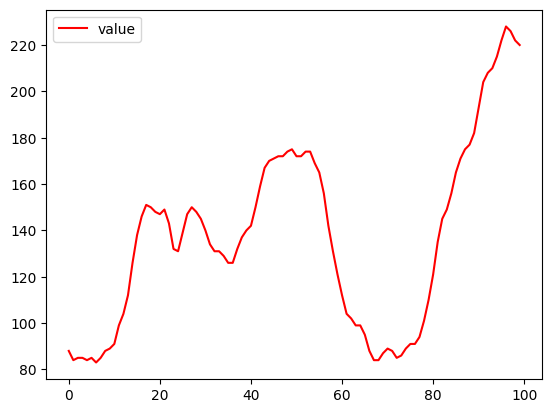

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value
#df.head()

df.plot(color = "red");

Bu soyut zaman serisi mevsimsel görünmüyor, ancak artan bir trend ve bir şekilde "yapışkan" (yani biraz oto-regresif) özellikler gösteriyor. Bu nedenle Oto-Regresif Hareketli Ortalama (ARIMA) modelleri için iyi bir aday olabilir.

## 2. ARIMA Modeli Oluşturma
ARIMA modelleri (Oto Regresif Entegre Hareketli Ortalama) sayesinde verileri tahmin etmeye çalışacağız.

Bunun için şunları yapmamız gerekecek:
1. zaman serisini nasıl durağanlaştırılacağını bulma (ARIMA'daki I)
2. oto-regresif (AR) kısmını bulma
3. hareketli ortalama (MA) kısmını bulma
4. Uydurma
5. Performansı değerlendirme

### Adım 1 - Durağanlığı Sağlama

ARIMA modelleri yalnızca "durağan" zaman serilerine uygulanır.

👉 [`Genişletilmiş Dickey-Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) kullanarak durağanlığını kesin olarak kontrol edin, özellikle p-değerini

In [27]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    p_value = result[1]
  

    print(f"ADF Statistics: {result[0]}")
    print(f"p-value: {p_value}")

    if p_value < 0.05:
        print("Seri durağandır")
    else:
        print("Seri durağan değildir")
        
res = adf_test(df["value"])
#print(res)



ADF Statistics: -2.4642397172033674
p-value: 0.12441935447109487
Seri durağan değildir


Durağanlıkta %95 güvenilirlik için p-değeri 0.05'ten küçük olmalıdır.
P-değeri 0.05'ten büyükse, boş hipotezi reddedemeriz (boş hipotez = "süreç durağan değildir").

Zaman serisi durağan değilse, **farklaştırma** yoluyla durağanlaştırılması gerekir.
- Bu, her değer ile bir önceki değer arasındaki farkı almak anlamına gelir (*birinci fark*).
- *İkinci fark* istiyorsanız, farklaştırılmış seri üzerinde işlemi tekrarlayın, vb...

👉 Durağan hale getirmek için ihtiyacımız olan minimum farklaştırma sırasını bulun (görselleştirmek için eğrileri çizin ve emin olmak için adfuller p-değerlerini yazdırın)

<details>
    <summary>İpucu</summary>

`pd.Series.diff`
</details>

d=0 → ADF p-value = 0.124419
d=1 → ADF p-value = 0.070268
d=2 → ADF p-value = 0.000000
d=3 → ADF p-value = 0.000000


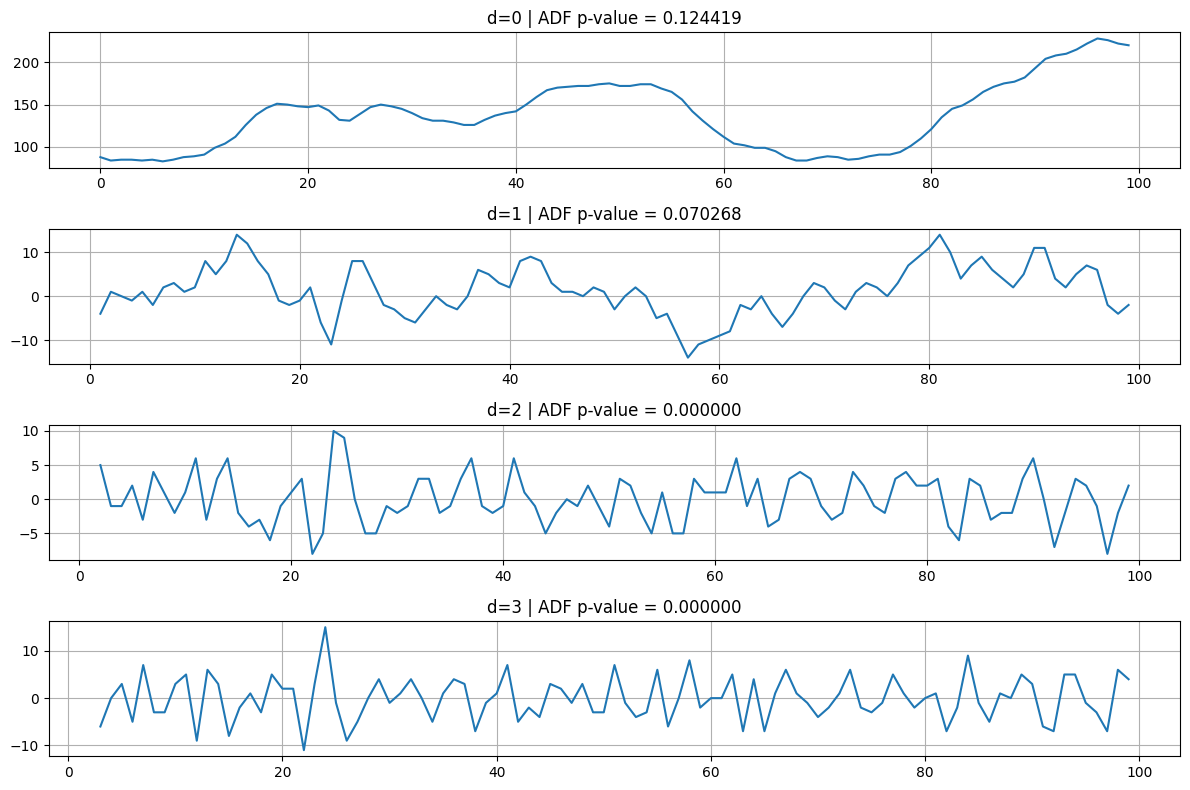

In [29]:
def difference_series(series, d):
    series = series.copy()
    for _ in range(d):
        series = series.diff()
    return series

plt.figure(figsize=(12, 8))

max_d = 3

for d in range(max_d + 1):

    if d == 0:
        temp = df["value"]
    else:
        temp = difference_series(df["value"], d)

    p_value = adfuller(temp.dropna())[1]

    plt.subplot(max_d + 1, 1, d + 1)
    plt.plot(temp)
    plt.title(f"d={d} | ADF p-value = {p_value:.6f}")
    plt.grid(True)

    print(f"d={d} → ADF p-value = {p_value:.6f}")

plt.tight_layout()
plt.show()


Burada bir ve iki fark sırası arasında yakın bir durumumuz var. Zaman serilerini fazla farklaştırmak ARIMA modellerinizin performansını da düşürebilir. Daha yakından bakalım:

👉 1. ve 2. fark sırası için otokorelasyon grafiğini ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) çizin.

(💡Profesyonel ipucu: Her statsmodels grafiği örneklemesinin sonuna `;` ekleyerek veya `plt.show()` çağırarak statsmodels grafiklerinin çoğaltılmasından kaçının)

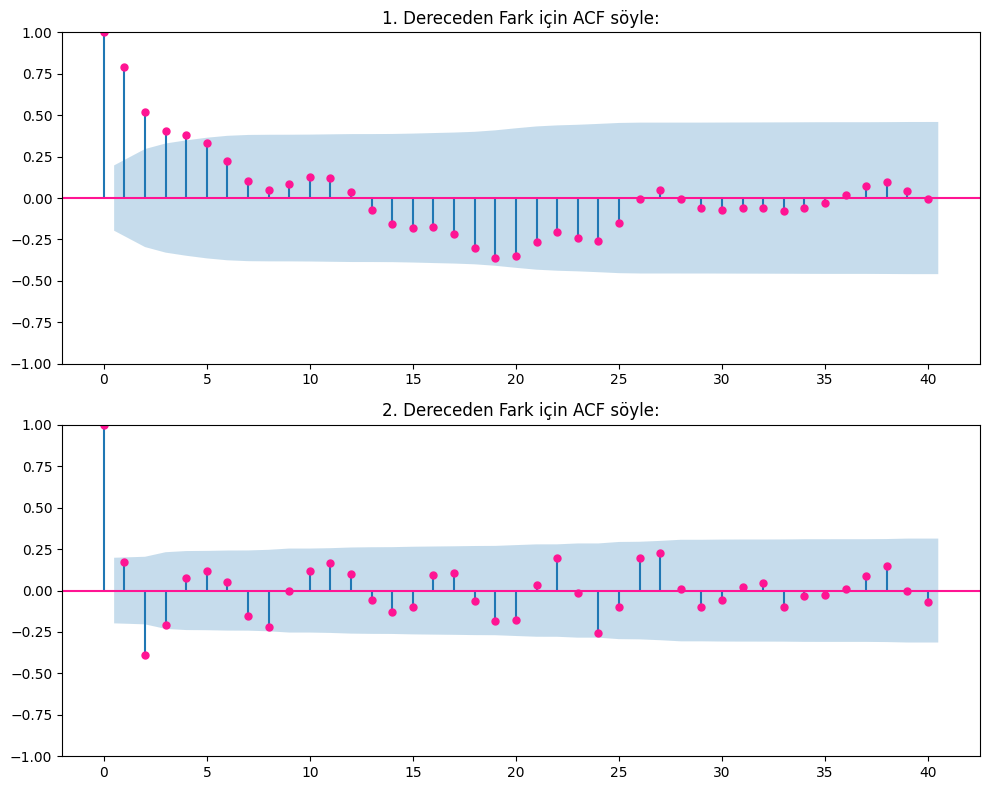

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
def difference_series(series, d):
    series = series.copy()
    for _ in range(d):
        series = series.diff()
    return series

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for i, d in enumerate([1, 2]):
    diff_series = difference_series(df["value"], d).dropna()

    plot_acf(
        diff_series,
        lags=40,
        ax=axes[i],
        color = "deeppink"
    )

    axes[i].set_title(f"{d}. Dereceden Fark için ACF söyle:")

plt.tight_layout()
plt.show()


"İkinci sıra fark" otokorelasyon grafiğimizde, 1 numaralı gecikme katsayısı 0'a yakın, ikincisi ise negatif bölgeye kadar uzanıyor. Bu, seriyi aşırı farklaştırdığımızı gösterebilir. (Unutmayın: her zaman 1'e eşit olan 0 numaralı gecikmeyİ hiçbir zaman umursamayız)

👉 (Geçici olarak) yalnızca bir fark sırasını tutalım ve bu seriyi `y_diff` olarak adlandıralım (daha sonra her zaman daha fazla fark deneyebiliriz)

In [35]:
d = 1
y_diff =difference_series(df["value"],d).dropna()
#y_diff = y.diff().dropna()
#y_diff

1    -4.0
2     1.0
3     0.0
4    -1.0
5     1.0
     ... 
95    7.0
96    6.0
97   -2.0
98   -4.0
99   -2.0
Name: value, Length: 99, dtype: float64

Az önce ARIMA'daki "I" terimini bulduk: durağan olmadan önce 1-fark için `d = 1` ("I", "entegrasyon"u ifade eder, "d" farklaştırma için...)

### Adım 2 - AR sırası (p) ve MA sırasını (q) seçin

#### MA($\color{blue}{q}$) = $Y^{\color{green}{(d)}}$'nin $\color{blue}{ACF}$'inin kesildiği gecikme sayısı

MA sırası (`q`), `y_diff`'e uygulanan otokorelasyon grafiğine ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bakılarak bulunabilir.

👉 `q`'yu belirleyin

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [43]:
q = 2

Modelimizi uydurma için değerlendirmemiz gereken maksimum değer q = 4 gibi görünüyor. Ancak, Otomatik-ARIMA kullanacak olsaydık (bu konuda daha sonra ayrıntılı bilgi), q=2 kullanmanın ideal sonuçlar verdiğini görürdük, bu nedenle başlangıçta q=2 ayarlamayı deneyelim.

Şüpheniz olduğunda, Y'yi yeterince açıklayan daha basit modeli seçin.

<Figure size 800x400 with 0 Axes>

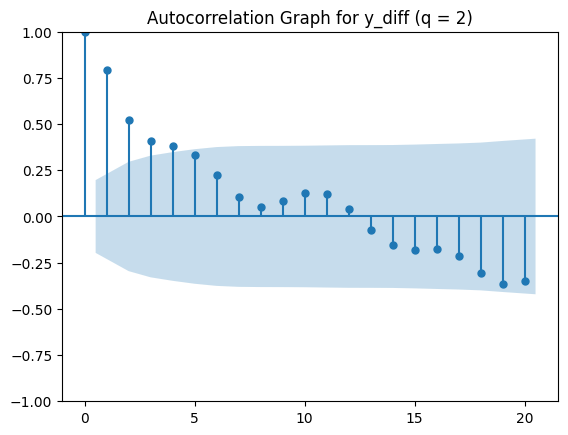

In [38]:
y_diff = difference_series(df["value"], 1).dropna()
plt.figure(figsize=(8, 4))

plot_acf(
    y_diff,
    lags=20  
)            

plt.title("Autocorrelation Graph for y_diff (q = 2)")
plt.show()


#### AR($\color{red}{p}$) = $Y^{\color{green}{(d)}}$'nin $\color{red}{PACF}$'inin kesildiği gecikme sayısı

AR sırası (`p`), `y_diff`'e uygulanan **k**ısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) incelenerek bulunabilir.

(Kısmi otokorelasyon, ara gecikmelerin katkılarını hariç tuttuktan sonra seri ile gecikmesi arasındaki korelasyon olarak düşünülebilir. Yani, PACF bir şekilde bir gecikme ile seri arasındaki saf korelasyonu iletir)

👉 `p`'yi belirleyin

<Figure size 800x400 with 0 Axes>

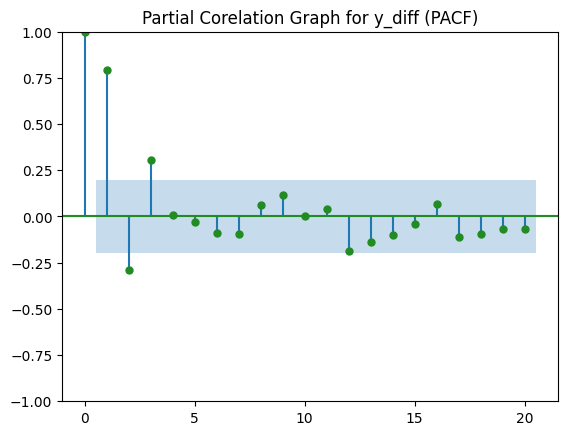

In [44]:
p = 1
y_diff = difference_series(df["value"], 1).dropna()
plt.figure(figsize=(8, 4))

plot_pacf(
    y_diff,
    lags=20,
    method="ywm" ,
    color = "forestgreen"
)

plt.title("Partial Corelation Graph for y_diff (PACF)")
plt.show()


İlk 3 gecikme terimi anlamlılık düzeyinin üstünde göründüğü için `p = 3` seçebiliriz, ancak daha basit bir model `p = 1` ile de gidebiliriz.

### Adım 3 - Modeli oluşturun

Artık ARIMA için `p`, `d` ve `q` değerlerini seçtiğinize göre,

👉 `statsmodels`'den `arima_model`'i oluşturun.
- modeli uydurur
- modeli yazdır (`.summary`)

In [45]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(
    df["value"],
    order=(p, d, q)
)
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Fri, 16 Jan 2026   AIC                            516.253
Time:                        14:36:58   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

☝️ P-değerleriniz çok yüksekse, karşılık gelen AR veya SA katsayılarını azaltarak bu terimleri kaldırmayı deneyin.

[`AIC - Akaike Bilgi Kriteri`](https://medium.com/towardsdatascience/the-akaike-information-criterion-c20c8fd832f2) değerini en aza indirerek uyumunuzun genel performansını değerlendirebilirsiniz

(1,1,1) ARIMA modellerinin aşırı uydurmaya karşı daha az şansı olduğu (p-değerleri düşük kalır) ve diğer modellerden neredeyse benzer bir AIC puanı koruduğu görülüyor

## 3. Model performansını değerlendirin

👉 `plot_predict()` yöntemi ile model tahminlerinizi görselleştirin

- Yöntemin varsayılan parametrelerine, özellikle `dynamic` parametrelerine yakından bakın.
- Modelinizin gerçekte böyle iyi bir performansa sahip olacağını düşünüyor musunuz?

In [57]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX


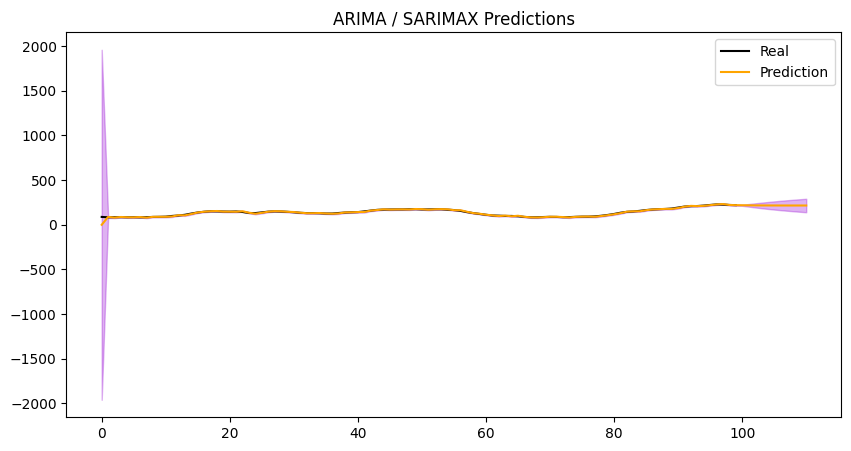

In [61]:
pred = model_fit.get_prediction(
    start=0,
    end=len(df) + 10
)
pred_ci = pred.conf_int()
fig, ax = plt.subplots(figsize=(10, 5))


df["value"].plot(ax=ax, label="Real", color="black")


pred.predicted_mean.plot(
    ax=ax,
    label="Prediction",
    color="orange"
)

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color="darkviolet",
    alpha=0.3
)

ax.set_title("ARIMA / SARIMAX Predictions")
ax.legend()

plt.show()

☝️ `dynamic=False`, `y_pred`'i tahmin etmek için mevcut tüm `y` değerlerini kullanır, bu da ARIMA tahminizin $y_t$'yi tahmin etmek için $y_{t-1}$'e kadar kullanmasını sağlar. Gerçekte, özellikle gelecekte birkaç aralığı tahmin etmek istiyorsanız tüm `y`'ye erişiminiz yoktur.

👉 Modelin yalnızca _85'e kadar verilere erişimi_ olan bir durumda _son 15 değeri_ tahmin eden bir tahmini çizmek için `dynamic=True` kullanmayı deneyin. Yani model:
- gerçek [1...85]'e dayalı olarak 86'yı tahmin eder
- sonra 86 için önceden tahmin ettiği değer _artı_ [1...85]'e dayalı olarak 87'yi tahmin eder
- vb...100'e kadar yinelemeli olarak

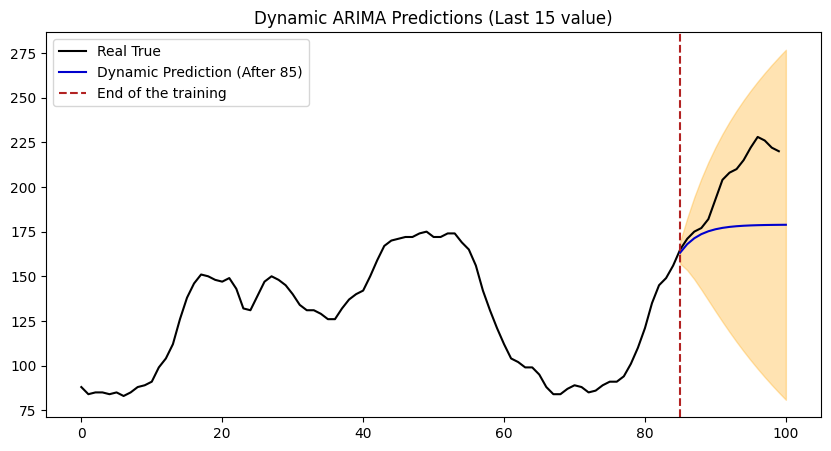

In [66]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 1, 1, 2

model = ARIMA(df["value"], order=(p, d, q))
model_fit = model.fit()
train_end = 85      
forecast_end = 100  


pred_dynamic = model_fit.get_prediction(
    start=train_end,
    end=forecast_end,
    dynamic=True
)
pred_ci = pred_dynamic.conf_int()


fig, ax = plt.subplots(figsize=(10, 5))


df["value"].plot(
    ax=ax,
    label="Real True",
    color="black"
)


pred_dynamic.predicted_mean.plot(
    ax=ax,
    label="Dynamic Prediction (After 85)",
    color="mediumblue"
)


ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color="orange",
    alpha=0.3
)


ax.axvline(
    x=train_end,
    color="firebrick",
    linestyle="--",
    label="End of the training"
)

ax.set_title("Dynamic ARIMA Predictions (Last 15 value)")
ax.legend()

plt.show()


☝️ Bu hala _gerçek_ bir tahmin değil! Neden?

<details>
    <summary>Cevap</summary>

Modelimiz uyum aşamasında tüm `y_true` serisini "gördü"!
</details>

### 3.1 Örneklem Dışı Tahminler (gerçek "gelecek")

👉 Test seti için yalnızca son 15 veri noktasını tutarak bir eğitim-test bölümü oluşturun ve ARIMA'nızı yalnızca eğitim setinde eğitin.

Length of training set: 85
Length of testing set: 15


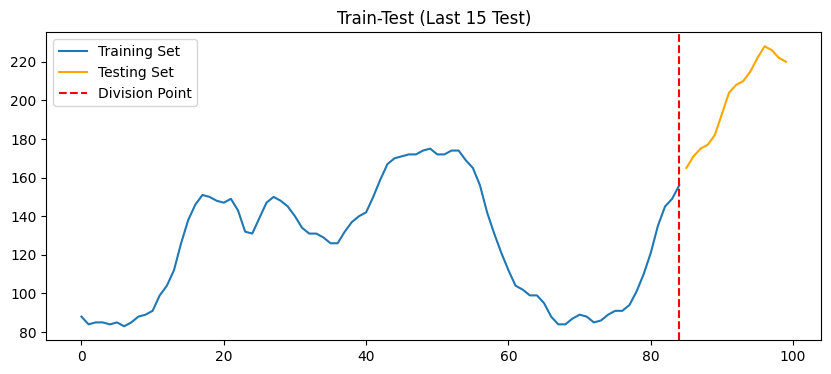

In [69]:
test_size = 15


train = df["value"][:-test_size]
test = df["value"][-test_size:]

print(f"Length of training set: {len(train)}")
print(f"Length of testing set: {len(test)}")


p, d, q = 1, 1, 2   

model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

plt.figure(figsize=(10, 4))
plt.plot(train, label="Training Set")
plt.plot(test, label="Testing Set", color="orange")
plt.axvline(train.index[-1], color="red", linestyle="--", label="Division Point")
plt.legend()
plt.title("Train-Test (Last 15 Test)")
plt.show()

👉 Şimdi 85. adımdayız ve geleceği hiç görmedik:
- Sonraki 15 veri noktasını (yani eğitim veri setinizin sonundan sonrasını) "tahmin etmek" için uydurduğunuz `arima` modelinde `get_forecast()` yöntemini kullanın

Yöntem `statsmodels`'den bir `PredictionResultsWrapper` nesnesi döndürür.

**💻 Bu sonucu `forecast_results` adlı bir değişkende saklayın.**

İlk başta gezinmek zordur, ancak işte bazı ipuçları:
- Tahminlerinizi `forecast_results.predicted_mean`'de bulabilirsiniz
- Güven aralıklarınız `forecast_results.conf_int()` tarafından verilir

In [74]:
forecast_steps = 15
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_results.predicted_mean
print(forecast_mean)
print("---------------------------")

forecast_ci = forecast_results.conf_int()
print(forecast_ci.head())


85    163.126755
86    167.854337
87    171.278009
88    173.757401
89    175.552955
90    176.853278
91    177.794960
92    178.476918
93    178.970785
94    179.328440
95    179.587450
96    179.775022
97    179.910861
98    180.009234
99    180.080475
Name: predicted_mean, dtype: float64
---------------------------
    lower value  upper value
85   156.900943   169.352568
86   153.293168   182.415506
87   148.418249   194.137770
88   142.816334   204.698469
89   136.886109   214.219800


👉 Tahmin edilen değerleri ve ayrıca %95 belirsizlik aralığının üst ve alt aralığını çizin

👉 Model performansını geçmişe göre daha iyi kavramak için önceki 85 `y` gerçek veri noktanızı da çizmeyi deneyin

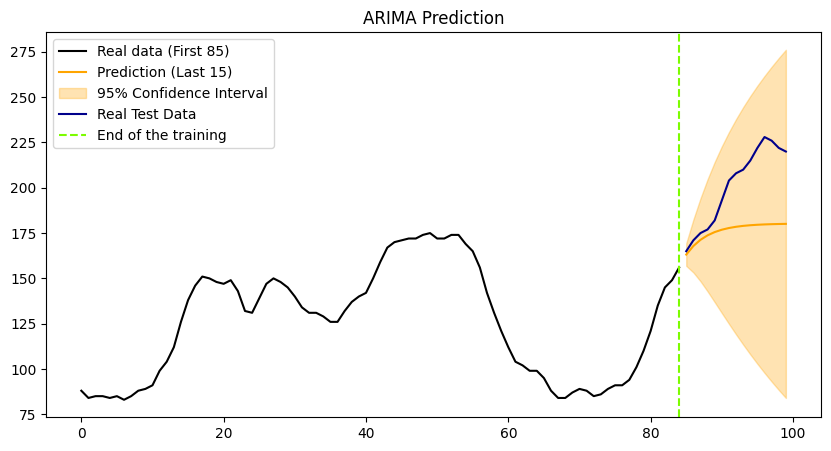

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))


train.plot(
    ax=ax,
    label="Real data (First 85)",
    color="black"
)


forecast_mean.plot(
    ax=ax,
    label="Prediction (Last 15)",
    color="orange"
)


ax.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="orange",
    alpha=0.3,
    label="95% Confidence Interval"
)


test.plot(
    ax=ax,
    label="Real Test Data",
    color="darkblue"
)


ax.axvline(
    train.index[-1],
    color="lawngreen",
    linestyle="--",
    label="End of the training"
)

ax.set_title("ARIMA Prediction")
ax.legend()

plt.show()

### 3.2 %95 güven aralığınıza güvenebilir misiniz? (çıkarım koşulları)

👉 Hiçbir örüntü olmadığından emin olmak için artıkları `model.resid` çizin
- Normal dağılım
- Sıfır ortalama
- Tekdüze varyans
- Oto-regresif örüntü yok (isterseniz artıkları plot_acf yapabilirsiniz)

Not: artıklar `plot_predict(dynamic=False)`'daki gibi tüm verileri 'görerek' oluşturulur

Ayrıca, artıkların yaklaşık olarak normal dağılımda olup olmadığını görmek için artıkların bir histogramını veya KDE uyumunu çizmeyi deneyin.

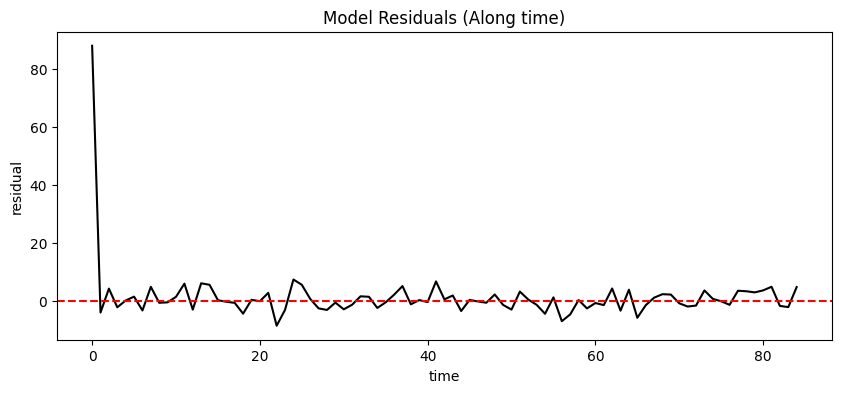

Mean of residuals: 1.26


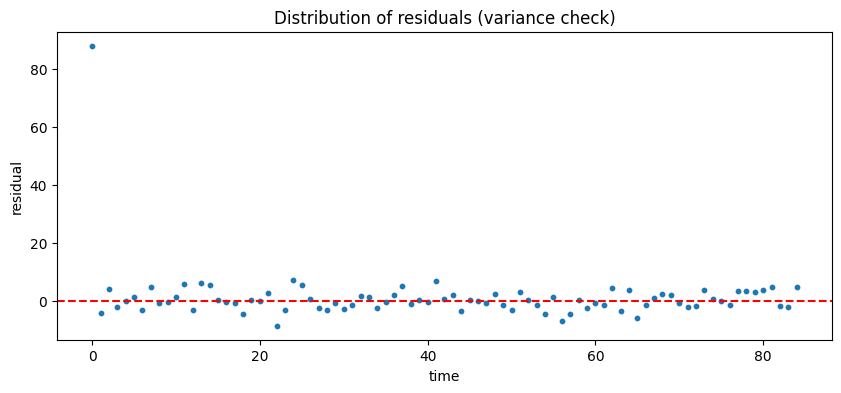

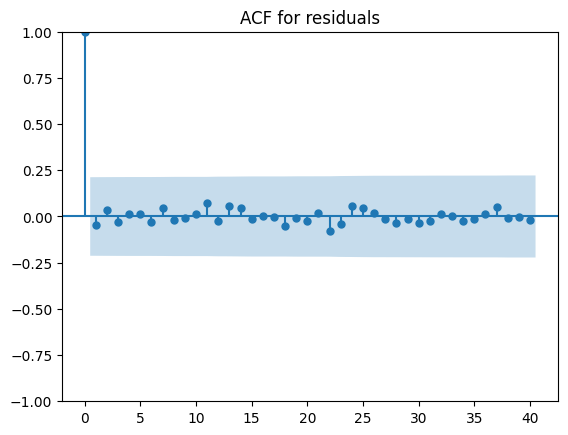

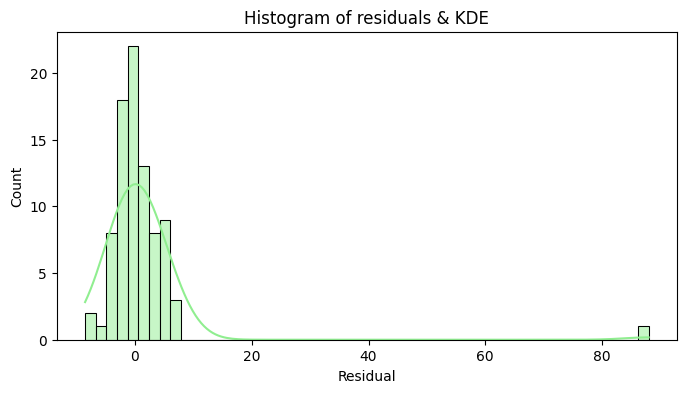

In [88]:
import seaborn as sns
residuals = model_fit.resid


plt.figure(figsize=(10, 4))
plt.plot(residuals, color="black")
plt.axhline(0, linestyle="--", color="red")
plt.title("Model Residuals (Along time)")
plt.xlabel("time")
plt.ylabel("residual")
plt.show()

print(f"Mean of residuals: {residuals.mean():.2f}")



plt.figure(figsize=(10, 4))
plt.scatter(range(len(residuals)), residuals, s=10)
plt.axhline(0, linestyle="--", color="red")
plt.title("Distribution of residuals (variance check)")
plt.xlabel("time")
plt.ylabel("residual")
plt.show()

plot_acf(residuals.dropna(), lags=40)
plt.title("ACF for residuals")
plt.show()


plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True,color="lightgreen")
plt.title("Histogram of residuals & KDE")
plt.xlabel("Residual")
plt.show()


## 3.3 Çapraz doğrulanmış performans ölçümleri

👉 Aşağıda zaman serileri için en yaygın performans ölçümleri yer almaktadır

In [89]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

👉 ARIMA hiper-parametrelerinizle oynayın ve tahmin performansınız üzerindeki etkisini görün

## 4 Izgara Arama

`pmdarima` kullanarak (p,d,q) için bir Izgara Arama çalıştırmayı deneyin. En azından şunları kullanın:
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

## (İsteğe bağlı) Modelinizin Performansını Çapraz Doğrulayın

Pratikte, sonuçlar ve Izgara Arama her zaman çapraz doğrulanmalıdır:

Modelinizin performansını gerçekten değerlendirmek ve çapraz doğrulamadan sonra en iyi hiperparametreleri bulmak için bitişik K-katlar oluşturmak amacıyla [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) kullanmaktan çekinmeyin.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - TimeSeriesSplit + Izgara Arama kullanarak Çapraz Doğrulama**

In [94]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)
def arima_cv_score(series, order, tscv):
    errors = []

    for train_idx, test_idx in tscv.split(series):
        train, test = series.iloc[train_idx], series.iloc[test_idx]

        model = ARIMA(train, order=order)
        model_fit = model.fit()

        forecast = model_fit.get_forecast(steps=len(test))
        forecast_mean = forecast.predicted_mean

        error = mean_squared_error(test, forecast_mean)
        errors.append(error)

    return np.mean(errors)
    
p_values = [0, 1, 2]
d_values = [1]        
q_values = [0, 1, 2]


best_score = float("inf")
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                order = (p, d, q)
                score = arima_cv_score(df["value"], order, tscv)

                print(f"ARIMA{order} → CV MSE: {score:.4f}")

                if score < best_score:
                    best_score = score
                    best_order = order

            except:
                continue
print(f"Best ARIMA Model: {best_order}")
print(f"Mean CV Error (MSE): {best_score:.4f}")



ARIMA(0, 1, 0) → CV MSE: 1679.1875
ARIMA(0, 1, 1) → CV MSE: 1709.1262


/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

ARIMA(0, 1, 2) → CV MSE: 1773.1618
ARIMA(1, 1, 0) → CV MSE: 1644.8870
ARIMA(1, 1, 1) → CV MSE: 1726.7610
ARIMA(1, 1, 2) → CV MSE: 1759.2289
ARIMA(2, 1, 0) → CV MSE: 1800.1136
ARIMA(2, 1, 1) → CV MSE: 1736.5966


/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) → CV MSE: 1719.7975
Best ARIMA Model: (1, 1, 0)
Mean CV Error (MSE): 1644.8870


In [96]:
#df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

☝️ İlk model seçimimiz (1, 1, 2) çok da kötü değil!
Veri seti (100 veri noktası) gerçekte herhangi bir şeyi çapraz doğrulamak için çok küçük olduğuna dikkat edin!